Importa o modelo a ser fatiado e mapeado

In [13]:
import matplotlib.pyplot as plt
import gui
import files
from timer import Timer
from components.layer import Layer
from os import getcwd

if not('folders' in globals()):
    home = getcwd()
    folders = files.System_Paths(home)
choice = gui.ask_load_or_begin()
if choice == "Novo Projeto":
    path_input, file_name = gui.load_model(folders)
    [dpi, layer_height] = gui.ask_parameters_input()
    with Timer("Fase 0: "):
        Layer.create_layers(folders, path_input, file_name, dpi, layer_height)
elif choice == "Carregar Salvo":
    gui.find_saved_file(folders)
elif choice == "Cancelar":
    quit

#TODO: encontrar uma forma de jogar layerHight para o slicing W/images (POSSIVELMENTE COM O RUNSINGLEMODEL)

Fase 0: 
criando as camadas
First arg: /home/matheus/Downloads/Tangran3/TangranV2/input/stl_models/chavinha90.stl
Second arg: 300.0
Script executed from: /home/matheus/Downloads/Tangran3/TangranV2
Script executed from: /home/matheus/Downloads/Tangran3/TangranV2/input/sliced
Script executed from: /home/matheus/Downloads/Tangran3/TangranV2
Script executed from: /home/matheus/Downloads/Tangran3/TangranV2/slicing-with-images
number of degenerated triangles = 0
eps = 0.004
max thickness = 2
rounded plane spacing spacing = 2
model zmin = -20.832, model zmax = 20, first plane Z = -22.828, number of planes = 23
-Incremental, chavinha90.stl, thickness = 2, #T = 312, #P = 21, #S = 1540, 0.000327s (slicing), 0.002149s (polygon assembling), 0.012839s (total), *K: 4.9359


rm: cannot remove '*.svg': No such file or directory
rm: cannot remove '*.png': No such file or directory




writing image: ../input/sliced/layer_000.pgm


writing image: ../input/sliced/layer_001.pgm


writing image: ../input/sliced/layer_002.pgm


writing image: ../input/sliced/layer_003.pgm


writing image: ../input/sliced/layer_004.pgm


writing image: ../input/sliced/layer_005.pgm


writing image: ../input/sliced/layer_006.pgm


writing image: ../input/sliced/layer_007.pgm


writing image: ../input/sliced/layer_008.pgm


writing image: ../input/sliced/layer_009.pgm


writing image: ../input/sliced/layer_010.pgm


writing image: ../input/sliced/layer_011.pgm


writing image: ../input/sliced/layer_012.pgm


writing image: ../input/sliced/layer_013.pgm


writing image: ../input/sliced/layer_014.pgm


writing image: ../input/sliced/layer_015.pgm


writing image: ../input/sliced/layer_016.pgm


writing image: ../input/sliced/layer_017.pgm


writing image: ../input/sliced/layer_018.pgm


writing image: ../input/sliced/layer_019.pgm


writing image: ../input/sliced/layer_020.pgm


writing out

Paredes Finas

In [14]:
import gui
import files
from timer import Timer
from os import getcwd

if not('folders' in globals()):
    home = getcwd()
    folders = files.System_Paths(home)
    gui.find_saved_file(folders)
[nozzle_diam_internal,nozzle_diam_external] = gui.ask_parameters_thin_walls()
camadas = folders.load_layers_hdf5()
for i,c in enumerate(camadas):
    with Timer("Fase 1: Camada: " + str(i)):
        folders.load_islands_hdf5(c)
        c.make_thin_walls(folders, nozzle_diam_external, nozzle_diam_internal)
        %reset_selective -f "c"
%reset_selective -f "camadas"
# TODO: arvore de paredes finas
# TODO: quando duas áreas se encontram
# TODO: limite de parede diam minimo
# TODO arrumar para origens extremamente pequenas, ignorar da problema
# TODO arrumar casos onde a beirada esta vazndo criando areas triangulares distantes
# FIXME: Precisa mesmo separar linha 1 2 topo e baixo? muitos elementos estão sendo criados

Fase 1: Camada: 0
Criando paredes finas
Total de [Criando paredes finas] : 7.489589691162109
Retirando Paredes finas da camada
Total de [Retirando Paredes finas da camada] : 0.002104043960571289
salvando imagens das regiões
Total de [salvando imagens das regiões] : 0.050133705139160156
Total de [Fase 1: Camada: 0] : 7.567928075790405
Fase 1: Camada: 1
Criando paredes finas
Total de [Criando paredes finas] : 6.884871244430542
Retirando Paredes finas da camada
Total de [Retirando Paredes finas da camada] : 0.0010802745819091797
salvando imagens das regiões
Total de [salvando imagens das regiões] : 0.03219127655029297
Total de [Fase 1: Camada: 1] : 6.936749458312988
Fase 1: Camada: 2
Criando paredes finas
Total de [Criando paredes finas] : 6.8503477573394775
Retirando Paredes finas da camada
Total de [Retirando Paredes finas da camada] : 0.00102996826171875
salvando imagens das regiões
Total de [salvando imagens das regiões] : 0.05188870429992676
Total de [Fase 1: Camada: 2] : 6.919021368

Contornos

In [15]:
import gui
import files
from timer import Timer
from components import layer
from os import getcwd

if not('folders' in globals()):
    home = getcwd()
    folders = files.System_Paths(home)
    gui.find_saved_file(folders)
[void_max,internal_max,external_max] = gui.ask_parameters_offsets()
camadas = folders.load_layers_hdf5()
for i,c in enumerate(camadas):
    with Timer("Fase 2: Camada: " + str(i)):
        folders.load_islands_hdf5(c)
        c.make_offsets(folders, void_max, external_max, internal_max)
        folders.save_props_hdf5(f"/{c.name}",c.__dict__)
        %reset_selective -f "c"
%reset_selective -f "camadas"

Fase 2: Camada: 0
Criando Lvls
Ilha: I_000 Número de Níveis: 5
Total de [Criando Lvls] : 3.838508129119873
Criando os loops
Total de [Criando os loops] : 1.7526767253875732
Criando regiões de influência
Total de [Criando regiões de influência] : 0.889857292175293
Criando as regiões de Offset
Total de [Criando as regiões de Offset] : 2.989811897277832
Retirando regiões da camada
['Lvl_000', 0, 0] Perdendo total:622 maior void:0.32852386237513875Bw -> aceito
['Lvl_000', 1, 0] Perdendo total:0 maior void:0Bw -> aceito
['Lvl_000', 1, 1] Perdendo total:0 maior void:0Bw -> aceito
['Lvl_001', 0, 0] Perdendo total:72672 maior void:78.2597114317425Bw -> bloqueado
['Lvl_002', 0, 0] Perdendo total:11852 maior void:5.847946725860155Bw -> bloqueado
['Lvl_003', 0, 0] Perdendo total:11285 maior void:5.700332963374029Bw -> bloqueado
['Lvl_004', 0, 0] Perdendo total:5394 maior void:2.591564927857936Bw -> bloqueado
['Lvl_001', 0, 1] Perdendo total:15883 maior void:8.793562708102108Bw -> bloqueado
['Lvl_

Pontes

In [16]:
import gui
import files
from timer import Timer
from components import layer
from os import getcwd
import numpy as np
from components import images_tools as it

if not('folders' in globals()):
    home = getcwd()
    folders = files.System_Paths(home)
    gui.find_saved_file(folders)
[n_max, nozzle_diam_internal] = gui.ask_parameters_bridges()
camadas = folders.load_layers_hdf5()
last_prohibited_areas = np.zeros(camadas[0].base_frame)
for i,c in enumerate(camadas):
    with Timer("Fase 3: Camada: " + str(i)):
        if i%2 == 1:
            last_image = it.rotate_img_cw(last_prohibited_areas )
        elif i%2 == 0:
            last_image = it.rotate_img_ccw(last_prohibited_areas )
        if i >= 2:
            if i%2 == 1:
                second_last_image = it.rotate_img_cw(camadas[i - 1].prohibited_areas)
            elif i%2 == 0:
                second_last_image = it.rotate_img_ccw(camadas[i - 1].prohibited_areas)
        else:
            second_last_image = np.zeros_like(last_image)
        c.prohibited_areas = last_image
        sum_prohibited_areas = it.sum_imgs([last_image, second_last_image])
        last_prohibited_areas = c.make_bridges(n_max, nozzle_diam_internal, folders, len(camadas), sum_prohibited_areas)
        folders.save_props_hdf5(f"/{c.name}",c.__dict__)
        # %reset_selective -f "c" 
%reset_selective -f "camadas"

Fase 3: Camada: 0
Criando pontes de Offset
Total de [Criando pontes de Offset] : 3.5434532165527344
Criando pontes de Zigzag
Fechou uma ponte OK
Fechou uma ponte OK
Total de [Criando pontes de Zigzag] : 27.48847460746765
Criando pontes de Crossover
Elemento: ('Reg_000', 'Reg_001') Maior prioridade: 0
Elemento: ('Reg_000', 'Reg_002') Maior prioridade: 1
Total de [Criando pontes de Crossover] : 0.10693168640136719
Retirando pontes da Camada
Total de [Retirando pontes da Camada] : 0.03247261047363281
Gerando áreas proibidas
Total de [Gerando áreas proibidas] : 0.003623485565185547
salvando imagens das regiões
Total de [salvando imagens das regiões] : 0.4672105312347412
Total de [Fase 3: Camada: 0] : 31.759562015533447
Fase 3: Camada: 1
Criando pontes de Offset
Total de [Criando pontes de Offset] : 4.153305768966675
Criando pontes de Zigzag
Fechou uma ponte OK
Fechou uma ponte OK
Total de [Criando pontes de Zigzag] : 23.351997137069702
Criando pontes de Crossover
Elemento: ('Reg_000', 'Reg

Zigzags

In [17]:
import gui
import files
from timer import Timer
from components import layer
from os import getcwd

if not('folders' in globals()):
    home = getcwd()
    folders = files.System_Paths(home)
    gui.find_saved_file(folders)
camadas = folders.load_layers_hdf5() 
for i, c in enumerate(camadas):
    with Timer("Fase 4: Camada: " + str(i)):
        c.make_zigzags(folders)
        %reset_selective -f "c"
%reset_selective -f "camadas"


Fase 4: Camada: 0
Encontrando areas monotonicas
Total de [Encontrando areas monotonicas] : 8.573335409164429
salvando imagens das regiões
Total de [salvando imagens das regiões] : 0.0304257869720459
Total de [Fase 4: Camada: 0] : 8.815575122833252
Fase 4: Camada: 1
Encontrando areas monotonicas
Total de [Encontrando areas monotonicas] : 1.3069820404052734
salvando imagens das regiões
Total de [salvando imagens das regiões] : 0.03549551963806152
Total de [Fase 4: Camada: 1] : 1.5154368877410889
Fase 4: Camada: 2
Encontrando areas monotonicas
Total de [Encontrando areas monotonicas] : 8.300404787063599
salvando imagens das regiões
Total de [salvando imagens das regiões] : 0.033838748931884766
Total de [Fase 4: Camada: 2] : 8.587694883346558
Fase 4: Camada: 3
Encontrando areas monotonicas
Total de [Encontrando areas monotonicas] : 1.1215803623199463
salvando imagens das regiões
Total de [salvando imagens das regiões] : 0.030485868453979492
Total de [Fase 4: Camada: 3] : 1.3310208320617676

iMAGEM DO MAPEAMENTO

Fase 4: Camada: 0


Total de [Fase 4: Camada: 0] : 1.2285449504852295
Fase 4: Camada: 1


Total de [Fase 4: Camada: 1] : 0.9132025241851807
Fase 4: Camada: 2


Total de [Fase 4: Camada: 2] : 0.6190445423126221
Fase 4: Camada: 3


Total de [Fase 4: Camada: 3] : 0.6180253028869629
Fase 4: Camada: 4


Total de [Fase 4: Camada: 4] : 0.8689107894897461
Fase 4: Camada: 5


Total de [Fase 4: Camada: 5] : 0.648029088973999
Fase 4: Camada: 6


Total de [Fase 4: Camada: 6] : 0.6333723068237305
Fase 4: Camada: 7


Total de [Fase 4: Camada: 7] : 0.6202893257141113
Fase 4: Camada: 8


Total de [Fase 4: Camada: 8] : 0.5995578765869141
Fase 4: Camada: 9


Total de [Fase 4: Camada: 9] : 0.6232292652130127


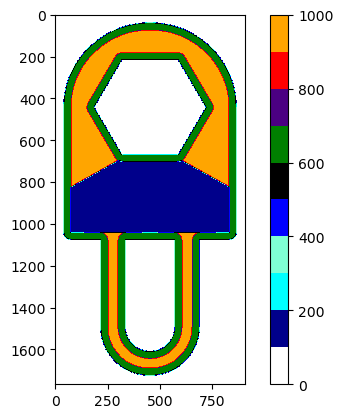

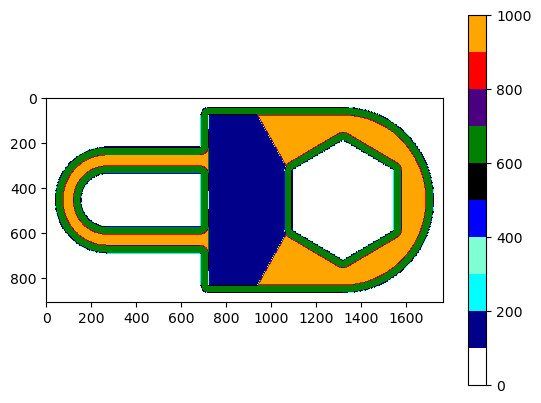

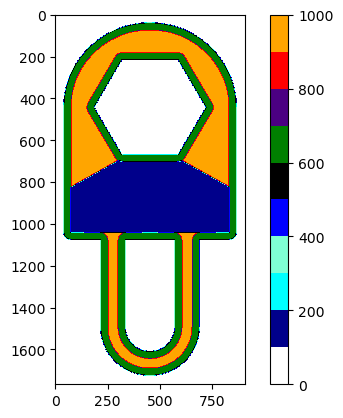

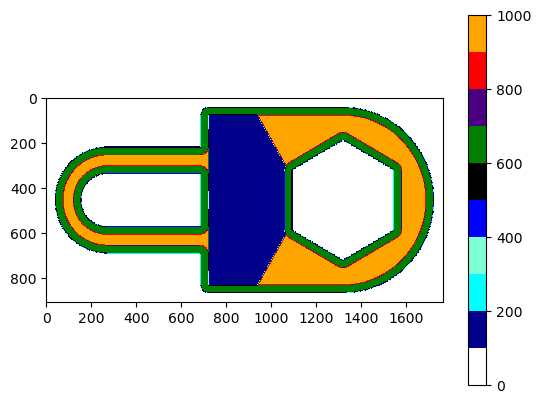

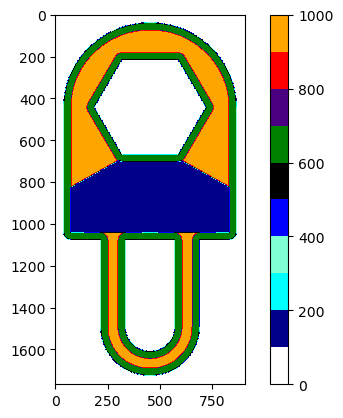

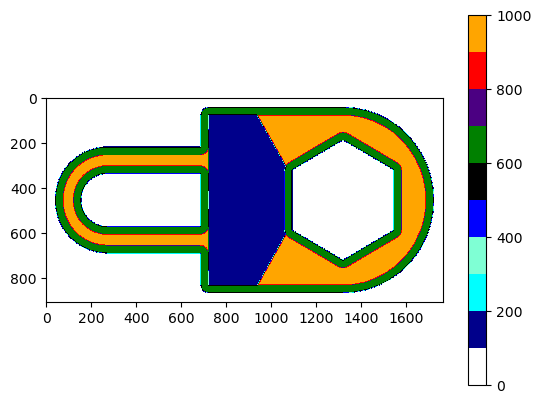

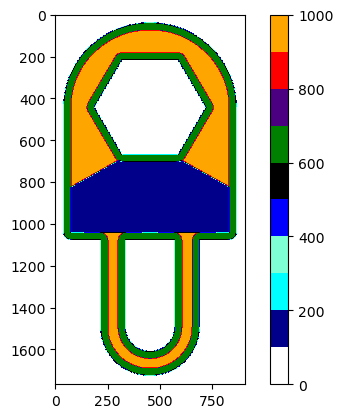

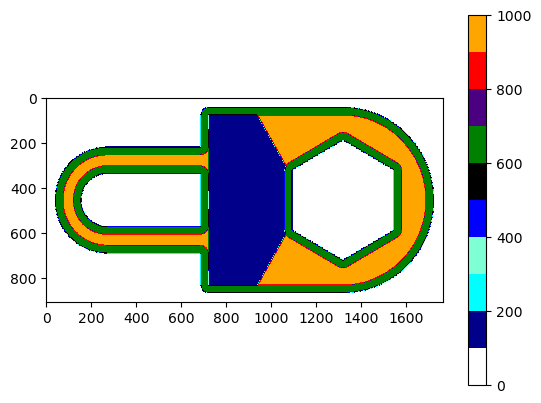

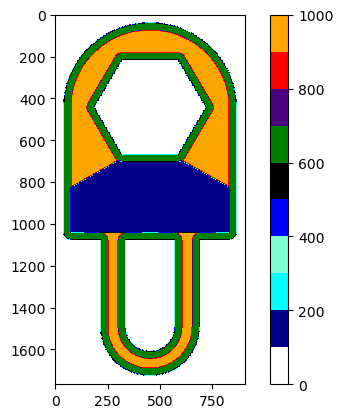

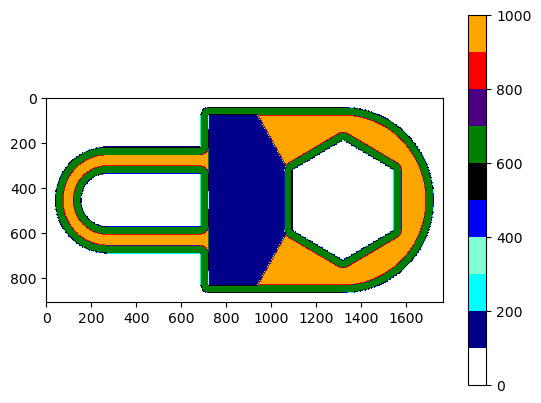

In [18]:
import gui
import files
from timer import Timer
from components import images_tools as it
from os import getcwd
import matplotlib.pyplot as plt
import matplotlib.colors
import os

if not('folders' in globals()):
    home = getcwd()
    folders = files.System_Paths(home)
    gui.find_saved_file(folders)
camadas = folders.load_layers_hdf5() 
for c in camadas:
    folders.load_islands_hdf5(c)
tangran_cmap = matplotlib.colors.ListedColormap(["white","darkblue","aqua","aquamarine","blue","black","green","indigo","red","orange"])
for i, c in enumerate(camadas):
    with Timer("Fase 4: Camada: " + str(i)):
        plt.figure()
        img_mapping = it.final_mapping(c, folders)
        # if i%2 == 1:
        #     img_mapping = it.rotate_img_ccw(img_mapping )
        plt.imshow(img_mapping, cmap=tangran_cmap, vmin=0, vmax=1000)
        plt.imsave("aaa.png",img_mapping, cmap=tangran_cmap, vmin=0, vmax=1000)
        plt.colorbar()
        print('\n')

ROTAS

Rotas de Offset

In [19]:
import gui
import files
from timer import Timer
from os import getcwd

if not('folders' in globals()):
    home = getcwd()
    folders = files.System_Paths(home)
    gui.find_saved_file(folders)
camadas = folders.load_layers_hdf5()

amendment_size = 0.7 #porcentagem do tamanho da poca de deposicao de material
for c in camadas:
    with Timer("Making offset routes"):
        c.make_offset_routes(amendment_size, folders)
        %reset_selective -f "c"
%reset_selective -f "camadas"

Making offset routes
salvando imagens das rotas
Total de [salvando imagens das rotas] : 0.21649622917175293
Total de [Making offset routes] : 8.450474739074707
Making offset routes
salvando imagens das rotas
Total de [salvando imagens das rotas] : 0.19031810760498047
Total de [Making offset routes] : 7.8675830364227295
Making offset routes
salvando imagens das rotas
Total de [salvando imagens das rotas] : 0.13660931587219238
Total de [Making offset routes] : 7.88883638381958
Making offset routes
salvando imagens das rotas
Total de [salvando imagens das rotas] : 0.18745207786560059
Total de [Making offset routes] : 8.213608026504517
Making offset routes
salvando imagens das rotas
Total de [salvando imagens das rotas] : 0.1433262825012207
Total de [Making offset routes] : 8.771815776824951
Making offset routes
salvando imagens das rotas
Total de [salvando imagens das rotas] : 0.13585400581359863
Total de [Making offset routes] : 8.333524942398071
Making offset routes
salvando imagens das

Rotas de pontes

In [1]:
import gui
import files
from timer import Timer
from os import getcwd

if not('folders' in globals()):
    home = getcwd()
    folders = files.System_Paths(home)
    gui.find_saved_file(folders)
camadas = folders.load_layers_hdf5()
for c in camadas:
    with Timer("Making bridges routes"):
        c.make_bridges_routes(folders)
        %reset_selective -f "c"
%reset_selective -f "camadas"

Making bridges routes
Value(False)
salvando imagens das rotas
Total de [salvando imagens das rotas] : 0.21558523178100586
Total de [Making bridges routes] : 307.0516743659973
Making bridges routes
salvando imagens das rotas
Total de [salvando imagens das rotas] : 0.16396832466125488
Total de [Making bridges routes] : 28.479100704193115
Making bridges routes
salvando imagens das rotas
Total de [salvando imagens das rotas] : 0.18849611282348633
Total de [Making bridges routes] : 28.18438410758972
Making bridges routes
salvando imagens das rotas
Total de [salvando imagens das rotas] : 0.18851041793823242
Total de [Making bridges routes] : 27.877849578857422
Making bridges routes
salvando imagens das rotas
Total de [salvando imagens das rotas] : 0.19495391845703125
Total de [Making bridges routes] : 27.824530124664307
Making bridges routes
salvando imagens das rotas
Total de [salvando imagens das rotas] : 0.23708367347717285
Total de [Making bridges routes] : 27.837505340576172
Making brid

Rotas de Ziguezague

In [21]:
import gui
import files
from timer import Timer
from os import getcwd

if not('folders' in globals()):
    home = getcwd()
    folders = files.System_Paths(home)
    gui.find_saved_file(folders)
camadas = folders.load_layers_hdf5()
for c in camadas:
    with Timer("Making zigzag routes"):
        c.make_zigzag_routes(folders)
        c.connect_zigzags(folders)
        %reset_selective -f "c"
%reset_selective -f "camadas"



Making zigzag routes
criando as rotas de zigzag, camada:L_000
fazendo as tres opções:
Total de [fazendo as tres opções:] : 18.170456409454346
escolhendo entre elas:
Total de [escolhendo entre elas:] : 0.5691559314727783
Total de [criando as rotas de zigzag, camada:L_000] : 20.485415935516357
salvando imagens das rotas
deletado: /L_000/I_000/zigzags
Total de [salvando imagens das rotas] : 0.08115434646606445
Criando os grafos de regiões
Total de [Criando os grafos de regiões] : 0.008736610412597656
Conectando regiões de zigzag
Total de [Conectando regiões de zigzag] : 0.004934549331665039
salvando grafos
Total de [salvando grafos] : 0.12836217880249023
Total de [Making zigzag routes] : 21.11503291130066
Making zigzag routes
criando as rotas de zigzag, camada:L_001
fazendo as tres opções:
Total de [fazendo as tres opções:] : 17.917256355285645
escolhendo entre elas:
Total de [escolhendo entre elas:] : 0.5113070011138916
Total de [criando as rotas de zigzag, camada:L_001] : 19.58212828636

WEAVING

In [22]:
import gui
import files
from timer import Timer
from os import getcwd

if not('folders' in globals()):
    home = getcwd()
    folders = files.System_Paths(home)
    gui.find_saved_file(folders)
camadas = folders.load_layers_hdf5()
[iwflag] = gui.ask_parameters_weaving()
for c in camadas:
    with Timer("Fase 5 b"):
        c.internal_weaving(iwflag, folders)
        %reset_selective -f "c"
%reset_selective -f "camadas"

Fase 5 b
gerando preenchimentos oscilatórios
Pegando as falhas internas
Total de [Pegando as falhas internas] : 0.7832779884338379
Achando os contatos
Total de [Achando os contatos] : 5.3281474113464355
criando os weavings
Total de [criando os weavings] : 3.773993492126465
Total de [gerando preenchimentos oscilatórios] : 14.939820289611816
salvando rotas
deletado: /L_000/I_000/zigzags/macro_areas
Total de [salvando rotas] : 0.22333717346191406
Total de [Fase 5 b] : 15.165196418762207
Fase 5 b
gerando preenchimentos oscilatórios
Pegando as falhas internas
Total de [Pegando as falhas internas] : 0.5708060264587402
Achando os contatos
Total de [Achando os contatos] : 1.127340316772461
criando os weavings
Total de [criando os weavings] : 1.0373976230621338
Total de [gerando preenchimentos oscilatórios] : 6.806581735610962
salvando rotas
deletado: /L_001/I_000/zigzags/macro_areas
Total de [salvando rotas] : 0.23119783401489258
Total de [Fase 5 b] : 7.040186643600464
Fase 5 b
gerando preench

Rotas de Thin Walls

In [23]:
import gui
import files
from timer import Timer
from os import getcwd

if not('folders' in globals()):
    home = getcwd()
    folders = files.System_Paths(home)
    gui.find_saved_file(folders)
camadas = folders.load_layers_hdf5()
for c in camadas:
    with Timer("Fase 5"):
        with Timer("Making thin walls routes"):
            c.make_thin_wall_routes(folders)
            %reset_selective -f "c"
%reset_selective -f "camadas"

Fase 5
Making thin walls routes
criando rotas TW
Total de [criando rotas TW] : 0.07041668891906738
salvando imagens das rotas
Total de [salvando imagens das rotas] : 2.6226043701171875e-05
Total de [Making thin walls routes] : 0.07128095626831055
Total de [Fase 5] : 0.0715639591217041
Fase 5
Making thin walls routes
criando rotas TW
Total de [criando rotas TW] : 0.05814051628112793
salvando imagens das rotas
Total de [salvando imagens das rotas] : 3.075599670410156e-05
Total de [Making thin walls routes] : 0.05884909629821777
Total de [Fase 5] : 0.05890989303588867
Fase 5
Making thin walls routes
criando rotas TW
Total de [criando rotas TW] : 0.06494283676147461
salvando imagens das rotas
Total de [salvando imagens das rotas] : 6.461143493652344e-05
Total de [Making thin walls routes] : 0.06609487533569336
Total de [Fase 5] : 0.066192626953125
Fase 5
Making thin walls routes
criando rotas TW
Total de [criando rotas TW] : 0.06493258476257324
salvando imagens das rotas
Total de [salvando

Encontrando o lugar onde será o começo da trilha de cada ilha

In [1]:
import gui
import files
from timer import Timer
from components import layer, path_tools
from os import getcwd

if not('folders' in globals()):
    home = getcwd()
    folders = files.System_Paths(home)
    gui.find_saved_file(folders)
camadas = folders.load_layers_hdf5()

for c in camadas:
    c.islands_path_starts(folders)

%reset_selective -f "camadas"                        

Encontrando ponto de união ext-int
salvando imagens das rotas
Value(False)
Total de [salvando imagens das rotas] : 58.32479214668274
Total de [Encontrando ponto de união ext-int] : 60.53815817832947
Encontrando ponto de união ext-int
salvando imagens das rotas
Total de [salvando imagens das rotas] : 11.681288719177246
Total de [Encontrando ponto de união ext-int] : 13.416085004806519
Encontrando ponto de união ext-int
salvando imagens das rotas
Total de [salvando imagens das rotas] : 2.005092144012451
Total de [Encontrando ponto de união ext-int] : 2.898611068725586
Encontrando ponto de união ext-int
salvando imagens das rotas
Total de [salvando imagens das rotas] : 1.5655510425567627
Total de [Encontrando ponto de união ext-int] : 2.224571943283081
Encontrando ponto de união ext-int
salvando imagens das rotas
Total de [salvando imagens das rotas] : 0.0022962093353271484
Total de [Encontrando ponto de união ext-int] : 0.744173526763916
Encontrando ponto de união ext-int
salvando imagen

Unificando rotas EXTERNAS nas camadas

In [1]:
import gui
import files
from timer import Timer
from os import getcwd

if not('folders' in globals()):
    home = getcwd()
    folders = files.System_Paths(home)
    gui.find_saved_file(folders)
camadas = folders.load_layers_hdf5()

for c in camadas:
    with Timer("Fase 6"):
        c.close_routes_external(folders)
        %reset_selective -f "c"
%reset_selective -f "camadas"
    

Fase 6
Conectando rotas externas
Conectando pontes de Offset
Total de [Conectando pontes de Offset] : 0.45407938957214355
Conectando pontes de Crossover
salto:  [1080, 319]
salto:  [667, 609]
Total de [Conectando pontes de Crossover] : 1.0629112720489502
Total de [Conectando rotas externas] : 2.0512702465057373
salvando imagens das rotas
deletado: /L_000/I_000/external_tree_route
Total de [salvando imagens das rotas] : 0.14443039894104004
Total de [Fase 6] : 2.196502685546875
Fase 6
Conectando rotas externas
Conectando pontes de Offset
Total de [Conectando pontes de Offset] : 0.3932793140411377
Conectando pontes de Crossover
salto:  [607, 1096]
salto:  [319, 686]
Total de [Conectando pontes de Crossover] : 1.0819709300994873
Total de [Conectando rotas externas] : 1.9430968761444092
salvando imagens das rotas
deletado: /L_001/I_000/external_tree_route
Total de [salvando imagens das rotas] : 0.16097784042358398
Total de [Fase 6] : 2.104567527770996
Fase 6
Conectando rotas externas
Conect

Unificando rotas INTERNAS nas camadas

In [2]:
import gui
import files
from timer import Timer
from components import layer
from os import getcwd

if not('folders' in globals()):
    home = getcwd()
    folders = files.System_Paths(home)
    gui.find_saved_file(folders)
camadas = folders.load_layers_hdf5()

for c in camadas:
    with Timer("Fase 7"):
        c.close_routes_internal(folders)
        %reset_selective -f "c"
%reset_selective -f "camadas"

Fase 7
Conectando zgzags vizinhos
Total de [Conectando zgzags vizinhos] : 2.0429582595825195
Conectando pontes de zigzag
Total de [Conectando pontes de zigzag] : 0.004004955291748047
salvando imagens das rotas
deletado: /L_000/I_000/internal_tree_route
Total de [salvando imagens das rotas] : 0.1798534393310547
Total de [Fase 7] : 2.676546096801758
Fase 7
Conectando zgzags vizinhos
Total de [Conectando zgzags vizinhos] : 1.468726634979248
Conectando pontes de zigzag
Total de [Conectando pontes de zigzag] : 0.002290964126586914
salvando imagens das rotas
deletado: /L_001/I_000/internal_tree_route
Total de [salvando imagens das rotas] : 0.11471796035766602
Total de [Fase 7] : 2.0138864517211914
Fase 7
Conectando zgzags vizinhos
Total de [Conectando zgzags vizinhos] : 1.5858886241912842
Conectando pontes de zigzag
Total de [Conectando pontes de zigzag] : 0.009570121765136719
salvando imagens das rotas
deletado: /L_002/I_000/internal_tree_route
Total de [salvando imagens das rotas] : 0.1227

Unindo rotas de thin walls

In [3]:
import gui
import files
from timer import Timer
from components import layer
from os import getcwd

if not('folders' in globals()):
    home = getcwd()
    folders = files.System_Paths(home)
    gui.find_saved_file(folders)
camadas = folders.load_layers_hdf5()

for c in camadas:
    with Timer("Fase 8"):
        c.close_routes_thinwalls(folders)
        %reset_selective -f "c"
%reset_selective -f "camadas"

Fase 8
Convertendo paredes finas
Total de [Convertendo paredes finas] : 0.0011599063873291016
salvando imagens das rotas
deletado: /L_000/I_000/thinwalls_tree_route/sequence
deletado: /L_000/I_000/thinwalls_tree_route/saltos
Total de [salvando imagens das rotas] : 0.10655832290649414
Total de [Fase 8] : 0.15636491775512695
Fase 8
Convertendo paredes finas
Total de [Convertendo paredes finas] : 0.0011899471282958984
salvando imagens das rotas
deletado: /L_001/I_000/thinwalls_tree_route/sequence
deletado: /L_001/I_000/thinwalls_tree_route/saltos
Total de [salvando imagens das rotas] : 0.11310505867004395
Total de [Fase 8] : 0.15342926979064941
Fase 8
Convertendo paredes finas
Total de [Convertendo paredes finas] : 0.0012552738189697266
salvando imagens das rotas
deletado: /L_002/I_000/thinwalls_tree_route/sequence
deletado: /L_002/I_000/thinwalls_tree_route/saltos
Total de [salvando imagens das rotas] : 0.1060483455657959
Total de [Fase 8] : 0.14899706840515137
Fase 8
Convertendo paredes

Unindo todas as rotas

In [4]:
import gui
import files
from timer import Timer
from components import layer, path_tools
from os import getcwd

if not('folders' in globals()):
    home = getcwd()
    folders = files.System_Paths(home)
    gui.find_saved_file(folders)
camadas = folders.load_layers_hdf5()

for c in camadas:
    c.close_final_path(folders)

%reset_selective -f "camadas"


Encontrando ponto de união ext-int
Total de [Encontrando ponto de união ext-int] : 0.04403567314147949
Conectando todas as partes
Total de [Conectando todas as partes] : 0.01713275909423828
salvando imagens das rotas
deletado: /L_000/I_000/island_route
[[912, 57], [1044, 57], [1045, 58], [1049, 58], [1050, 59], [1052, 59], [1059, 66], [1059, 68], [1060, 69], [1060, 73], [1061, 74], [1061, 215], [1062, 216], [1062, 220], [1063, 221], [1063, 223], [1066, 226], [1066, 227], [1072, 232], [1074, 232], [1075, 233], [1079, 233], [1080, 234], [1508, 234], [1509, 235], [1521, 235], [1522, 236], [1531, 236], [1532, 237], [1540, 238], [1544, 240], [1547, 240], [1548, 241], [1551, 241], [1555, 243], [1558, 243], [1559, 244], [1565, 245], [1570, 248], [1572, 248], [1577, 251], [1579, 251], [1584, 254], [1586, 254], [1591, 257], [1593, 257], [1599, 260], [1601, 262], [1611, 268], [1614, 271], [1624, 277], [1627, 280], [1628, 280], [1640, 292], [1641, 292], [1657, 308], [1660, 313], [1664, 317], [166

Gerando o Código G

In [1]:
import gui
import files
from timer import Timer
from components import layer, path_tools
from os import getcwd

if not('folders' in globals()):
    home = getcwd()
    folders = files.System_Paths(home)
    gui.find_saved_file(folders)
[vel_int, vel_ext, vel_thin_wall, p_religamento, p_desligamento, vel_vazio, p_entre_camadas, substratoy, substratox, cortey, cortex] = gui.ask_parameters_Gcode()
coords_substrato = [substratoy, substratox]
coords_corte = [cortey, cortex]
camadas = folders.load_layers_hdf5()

#layer_heights = [10+2.9+3+(i*1.5) for i,x in enumerate(camadas)]
layer_heights = [20+8+2+(i*1.5) for i,x in enumerate(camadas)]
with Timer("Cuspindo o Gcode"):
    path_tools.layers_to_Gcode(camadas, 
                               folders, 
                               vel_int,
                               vel_ext, 
                               vel_thin_wall, 
                               p_religamento,
                               p_desligamento,
                               vel_vazio,
                               p_entre_camadas,
                               layer_heights,
                               coords_substrato,
                               coords_corte,
                               )
%reset_selective -f "camadas"

Cuspindo o Gcode
nome: L_000/I_000
[[912, 57], [1044, 57], [1045, 58], [1049, 58], [1050, 59], [1052, 59], [1059, 66], [1059, 68], [1060, 69], [1060, 73], [1061, 74], [1061, 215], [1062, 216], [1062, 220], [1063, 221], [1063, 223], [1066, 226], [1066, 227], [1072, 232], [1074, 232], [1075, 233], [1079, 233], [1080, 234], [1508, 234], [1509, 235], [1521, 235], [1522, 236], [1531, 236], [1532, 237], [1540, 238], [1544, 240], [1547, 240], [1548, 241], [1551, 241], [1555, 243], [1558, 243], [1559, 244], [1565, 245], [1570, 248], [1572, 248], [1577, 251], [1579, 251], [1584, 254], [1586, 254], [1591, 257], [1593, 257], [1599, 260], [1601, 262], [1611, 268], [1614, 271], [1624, 277], [1627, 280], [1628, 280], [1640, 292], [1641, 292], [1657, 308], [1660, 313], [1664, 317], [1664, 318], [1676, 333], [1682, 346], [1684, 348], [1693, 366], [1693, 368], [1694, 369], [1694, 371], [1695, 372], [1695, 374], [1696, 375], [1696, 377], [1697, 378], [1697, 380], [1698, 381], [1698, 383], [1699, 384], [

In [ ]:
# import numpy as np
# camadas = folders.load_layers_hdf5()
# for c in camadas:
#     folders.load_islands_hdf5(c)
#     for isl in c.islands:
#         folders.load_island_paths_hdf5(c.name, isl)
#         internal_trees = [list(x) for x in isl.internal_tree_route.sequence]
#         print(internal_trees)
# print([235,807] in internal_trees)

In [ ]:
# import matplotlib.pyplot as plt
# from mpl_toolkits.mplot3d import Axes3D
# import numpy as np

# # Lista de imagens binárias (exemplo com arrays numpy)
# imagens = [
#     img_mapping,
#     img_mapping,
#     img_mapping
# ]

# # Lista de alturas no eixo z
# alturas = [0, 10, 20]

# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')

# for img, z in zip(imagens, alturas):
#     x = np.linspace(0, img.shape[1], img.shape[1])
#     y = np.linspace(0, img.shape[0], img.shape[0])
#     x, y = np.meshgrid(x, y)
#     z = np.full_like(x, z)
#     ax.plot_surface(x, y, z, rstride=1, cstride=1, facecolors=plt.cm.gray(img), shade=False)

# ax.set_xlabel('X')
# ax.set_ylabel('Y')
# ax.set_zlabel('Z')
# plt.show()


In [ ]:
# import gui
# import files
# from timer import Timer
# from components import layer, path_tools
# from os import getcwd

# if not('folders' in globals()):
#     home = getcwd()
#     folders = files.System_Paths(home)
#     gui.find_saved_file(folders)
# camadas = folders.load_layers_hdf5()

# file_name = gui.find_saved_file(folders)
# path_tools.layers_to_Gcode_FFF(camadas, folders, file_name)

In [ ]:
# class TrafficLightState:
#     """Base class for traffic light states."""
#     def change(self, traffic_light):
#         raise NotImplementedError("This method should be overridden by subclasses")


# class RedState(TrafficLightState):
#     """State representing the red light."""
#     def change(self, traffic_light):
#         print("Changing from Red to Green")
#         traffic_light.state = GreenState()


# class YellowState(TrafficLightState):
#     """State representing the yellow light."""
#     def change(self, traffic_light):
#         print("Changing from Yellow to Red")
#         traffic_light.state = RedState()


# class GreenState(TrafficLightState):
#     """State representing the green light."""
#     def change(self, traffic_light):
#         print("Changing from Green to Yellow")
#         traffic_light.state = YellowState()


# class TrafficLight:
#     """Traffic light class that uses a state machine."""
#     def __init__(self):
#         self.state = RedState()  # Initial state

#     def change(self):
#         """Change the state of the traffic light."""
#         self.state.change(self)

#     def __str__(self):
#         return f"Current state: {self.state.__class__.__name__}"


# # Example usage
# if __name__ == "__main__":
#     traffic_light = TrafficLight()
    
#     # Simulate the traffic light changing states
#     for _ in range(6):  # Change state 6 times
#         print(traffic_light)
#         traffic_light.change()

In [ ]:
# import numpy as np
# import cv2  # Assuming you are using OpenCV for image processing

# def bobobo(image1, image2):
#     """A placeholder function that performs some operation on two images."""
#     # For demonstration, let's just return the absolute difference between the two images
#     return cv2.absdiff(image1, image2)

# def process_images(image_list):
#     """Process a list of images, comparing the last two with the current image."""
#     for i in range(len(image_list)):
#         current_image = image_list[i]
        
#         # Check if there are at least two previous images to compare
#         if i >= 2:
#             last_image = image_list[i - 1]
#             second_last_image = image_list[i - 2]
            
#             # Apply the bobobo function to the current image and the last two images
#             result_last = bobobo(current_image, last_image)
#             result_second_last = bobobo(current_image, second_last_image)
            
#             # Here you can do something with the results, like saving or displaying them
#             # For demonstration, we'll just print the shapes of the results
#             print(f"Comparing image {i} with last image {i-1}: result shape = {result_last.shape}")
#             print(f"Comparing image {i} with second last image {i-2}: result shape = {result_second_last.shape}")

# # Example usage
# if __name__ == "__main__":
#     # Create a list of dummy images (for demonstration purposes)
#     # In practice, you would load your images using cv2.imread or similar
#     image_list = [np.random.randint(0, 256, (100, 100, 3), dtype=np.uint8) for _ in range(5)]
    
#     process_images(image_list)